# Final Project: Autostereograms

## CS445: Computational Photography

### Part I: Familiarization

In [1]:
#  Let's make some ASCII stereograms!
# Your eyes converge ( /\ ) or diverge ( \/ ) depending on the 3D depth of what they're looking at
# We can simulate looking at a single object at a distance X by looking at two identical objects at a distance less than X:


#     a  a  a  a  a  a  a  a  a  a  a  a  a 
#     b   b   b   b   b   b   b   b   b   b
#     c    c    c    c    c    c    c    c
#     d     d     d     d     d     d     d
#     c    c    c    c    c    c    c    c
#     b   b   b   b   b   b   b   b   b   b
#     a  a  a  a  a  a  a  a  a  a  a  a  a

#  There's a slight problem with the one above: the period of the 'a' is ambiguous.
#  when you look at the 'd' row, the 'a' row will appear to be the same, when it should really be closer
    
#     CloseCloseCloseCloseCloseCloseCloseClose
#     Far   Far   Far   Far   Far   Far   Far   
#     FurtherFurtherFurtherFurtherFurther
#     FurthestFurthestFurthestFurthestFurthest

In [2]:
# import libraries
import cv2
import numpy as np
from matplotlib.colors import LogNorm
from scipy import signal
%matplotlib inline  
import matplotlib.pyplot as plt
import matplotlib.animation
# define working directory
# datadir = "./" 

### Part II: Random Dot Autostereograms

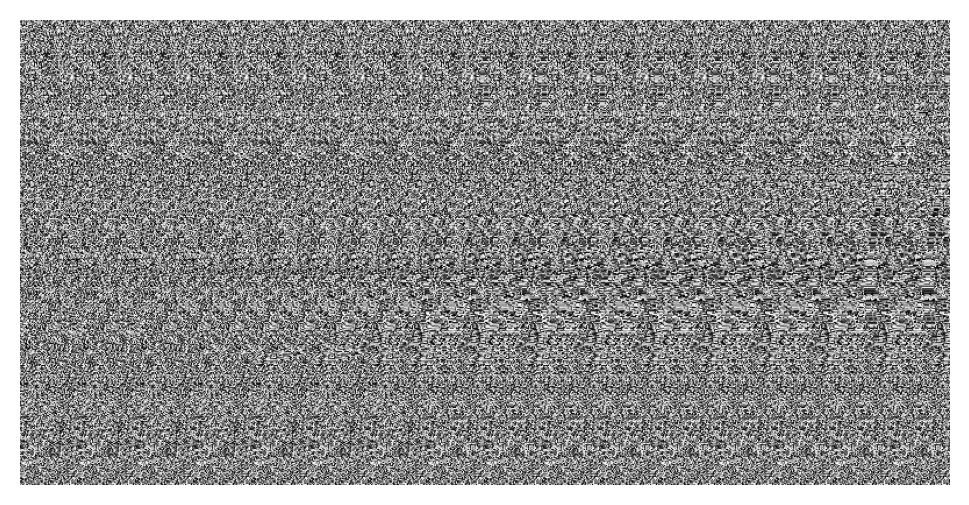

In [3]:
plt.rcParams['figure.dpi'] = 200

def make_stereogram(depth_img):

    intensity = 0.6 # intensity of 3D depth (0.0-1.0)
    patch_w = 50    # repeat-period corresponding to depth=0 in pixels
    out_size = (out_h, out_w) = (depth_img.shape[0], depth_img.shape[1]+patch_w)
    out = np.zeros(out_size).astype('double')

    for r, row in enumerate(out):
        # start with random array for row
        seed = np.random.random(patch_w)
        row[0:patch_w] = seed
        # sample remaining pixels in row based on depth
        for c in range(0, depth_img.shape[1]):
            depth = depth_img[r,c]
            offset = round(depth*patch_w*intensity)
            out[r, c+patch_w] = out[r, c+offset]
    out = out[:,patch_w:] # remove seed columns so image is centered
    return out

plt.axis('off')
depth_img = cv2.cvtColor(cv2.imread('images/shark_depth.png'), cv2.COLOR_BGR2GRAY).astype('double') / 255.0
plt.imshow(make_stereogram(depth_img), cmap='gray', vmin=0, vmax=1)
plt.show()

### Part III: Textured Autostereograms

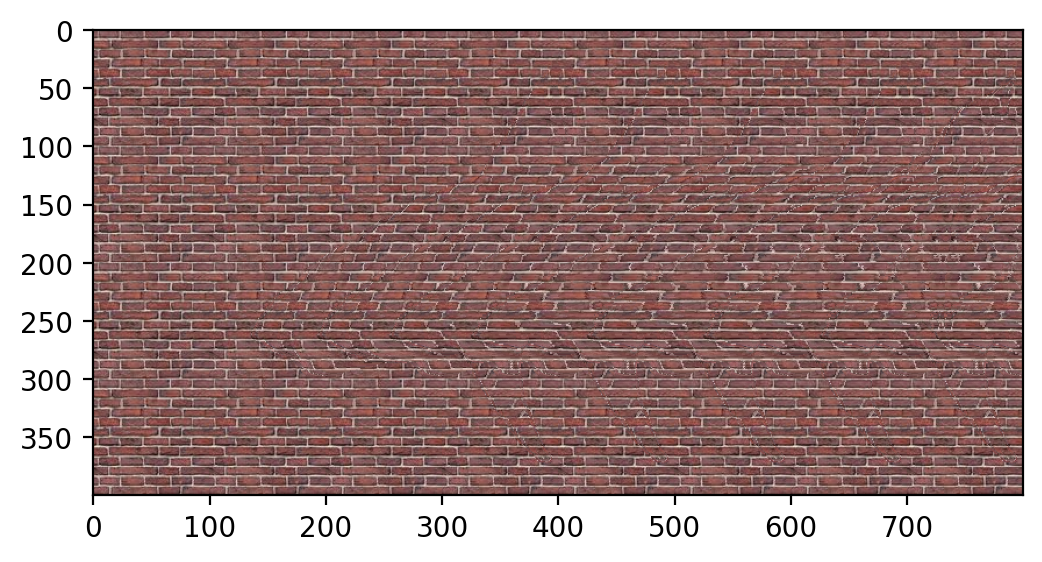

In [4]:
plt.rcParams['figure.dpi'] = 200

intensity = 0.6 # intensity of 3D depth (0.0-1.0)
depth_img = cv2.cvtColor(cv2.imread('images/shark_depth.png'), cv2.COLOR_BGR2GRAY).astype('double') / 255.0
tex_img = cv2.cvtColor(cv2.imread('images/bricks.jpg'), cv2.COLOR_BGR2RGB) / 255.0
patch_w = tex_img.shape[1]
out_size = (out_h, out_w) = (depth_img.shape[0], depth_img.shape[1]+patch_w)
out = np.zeros((*out_size,3)).astype('double')

for r, row in enumerate(out):
    # seed is now a row of the given texture
    seed = tex_img[r % tex_img.shape[0], 0:patch_w]
    row[0:patch_w] = seed
    # sample remaining pixels in row based on depth
    for c in range(0, depth_img.shape[1]):
        depth = depth_img[r,c]
        offset = round(depth*patch_w*intensity)
        out[r, c+patch_w] = out[r, c+offset]
out = out[:,patch_w:] # remove seed columns so image is centered

plt.imshow(out, cmap='gray', vmin=0, vmax=1)
plt.show()

### Extensions

In [5]:
# %matplotlib qt
# plt.rcParams['figure.dpi'] = 200
# plt.grid(b=None)
# # plt.ion()
# fig = plt.figure()


# depth_img = cv2.cvtColor(cv2.imread('shark_depth.png'), cv2.COLOR_BGR2GRAY).astype('double') / 255.0
# out_size = (out_h, out_w) = (depth_img.shape[0], depth_img.shape[1])


# for shift in range(-200, 200, 20):
#     # shift = -50
#     out = np.zeros(out_size).astype('double')
#     for r in range(out_h):
#         for c in range(out_w):
#             z = depth_img[r,c]
#             s = max(min(c+int(z*shift), out_w-1),0)
#             out[r,c] = depth_img[r,s]

#     plt.imshow(make_stereogram(out), cmap='gray', vmin=0, vmax=1)
#     fig.canvas.draw()
#     fig.canvas.flush_events()
#     plt.clf()

### Decoding Autostereograms

In [6]:
from tqdm import tqdm

In [7]:

# caclulate the value of a row
# using the integral image
def idxToSum(x1,x2,y,integral):
    # assume x2 > x1
    p3 = integral[y+1][x2+1]
    p2 = integral[y+1][x1-1]
    p1 = integral[y  ][x2+1]
    p0 = integral[y  ][x1-1]
    val = p3-p2-p1+p0
    return val
    
def integralWindow(x1,y1,x2,y2, integral):
    p3 = integral[y2][x2]
    p2 = integral[y2][x1]
    p1 = integral[y1][x2]
    p0 = integral[y1][x1]
    val = p3-p2-p1+p0
    return val
    

In [45]:
# def findOptimalWindow(img, integral, minSplit=4, maxSplit=16):
#     maxWin = int(img.shape[1] / minSplit)
#     minWin = int(img.shape[1] / maxSplit)
#     vals = []
#     for i in range(minWin,maxWin):
#         left  = integralWindow(0, 0, i,   img.shape[0], integral)
#         right = integralWindow(0, i, 2*i, img.shape[0], integral)
#         vals.append(np.abs(left-right)/(i*img.shape[0]))
#     return np.where(np.array(vals)==np.min(vals))[0][0]

def findOptimalWindow(img, integral, minSplit=4, maxSplit=16):
    maxWin = int(img.shape[1] / minSplit)
    minWin = int(img.shape[1] / maxSplit)
    vals = []
    size = 20
    for i in range(minWin,maxWin):
        # compute ssd of square patch from top left with sqare patch of the 2nd column
        ssd = np.abs(np.sum((img[0:size, 0:size]-img[0:size, i:i+size])**2))
        vals.append((ssd, i))
    # finally take the minimum ssd value from the list and return its window size
    return sorted(vals)[0][1]



In [46]:
# get depth map
def doMagicEye(img, integral, window, samplesz):
    dmap = np.zeros((img.shape[0], img.shape[1]-window),dtype='int32')
    # really wish I could get rid of this iteration
    for vidx in tqdm(range(1,img.shape[0]-1)): # for each row
        for hidx in range(1,img.shape[1]-window-1): #for each pixel in the row
            # get the sum of a horz chunk
            sample = idxToSum(hidx,hidx+samplesz,vidx,integral)
            # try and grok this, go thru a search window, calc the abs diff of sums
            # between or sample and the test window, toss in a list
            vals = [np.abs(sample-idxToSum(hidx+sidx,hidx+sidx+samplesz,vidx,integral)) for sidx in range(int(window*0.5),window-samplesz) ]
            # find the minimum match
            best = np.where(np.array(vals)==np.min(vals))[0]
            # offset is the hidx of the current window       
            dmap[vidx][hidx] = best[-1] # if we get > 1 use the furthest one
    return dmap


(400, 800, 3)


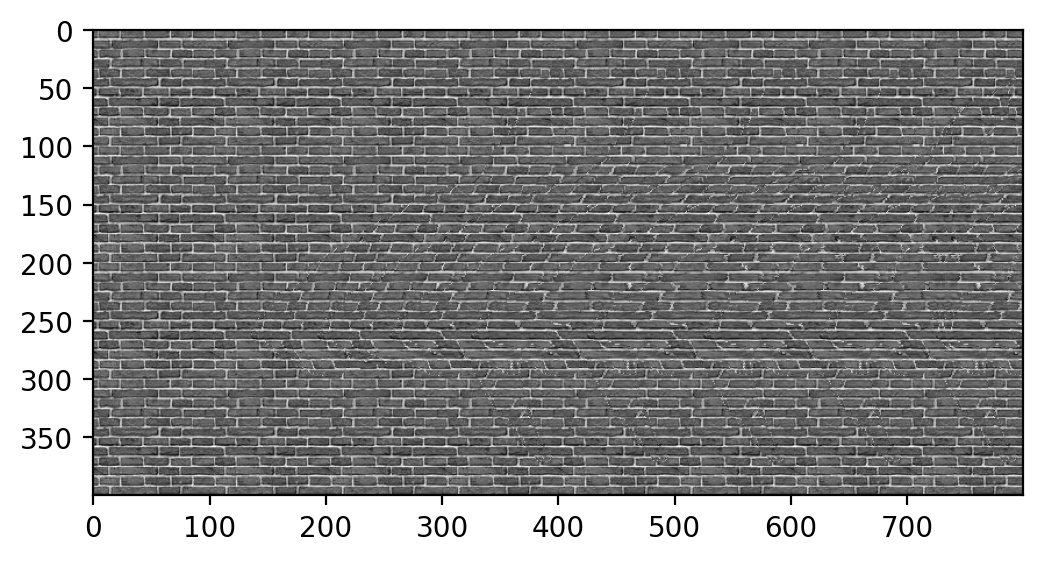

1.0
image: 800x400
window: 100
sample: 10


100%|█████████████████████████████████████████| 398/398 [00:17<00:00, 22.46it/s]


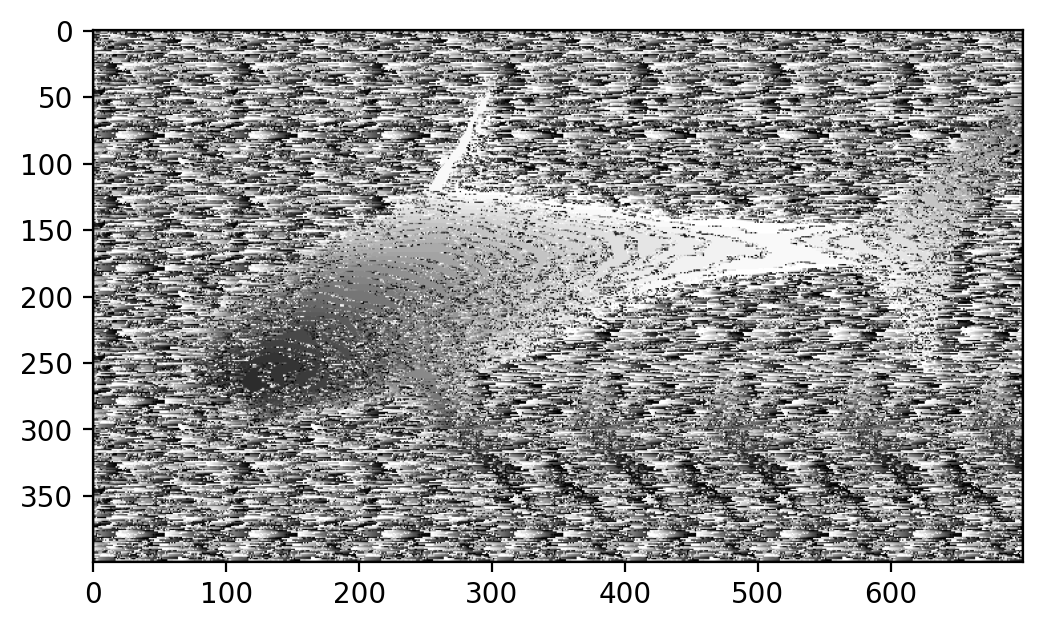

In [47]:
searchWndw = 1.0

# open image and create integral image
# img = cv2.cvtColor(out, cv2.COLOR_BGR2GRAY).astype('double') / 255.0
img = out
print(img.shape)
img = cv2.cvtColor(img.astype('float32'), cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap="gray")
plt.show()

# create the integral image
integral = cv2.integral(img)

# find our search window and make it big
window = int(searchWndw*findOptimalWindow(img,integral))
print(searchWndw)
print("image: {0}x{1}".format(img.shape[1], img.shape[0]))
print("window: {0}".format(window))

# how big of a signal we match on 
samplesz = window // 10
print("sample: {0}".format(samplesz))
numProc = 4
dmap = doMagicEye(img, integral, window, samplesz)

plt.imshow(dmap, cmap="gray")
plt.show()

<class 'numpy.ndarray'>
(400, 700)
<class 'numpy.uint8'>


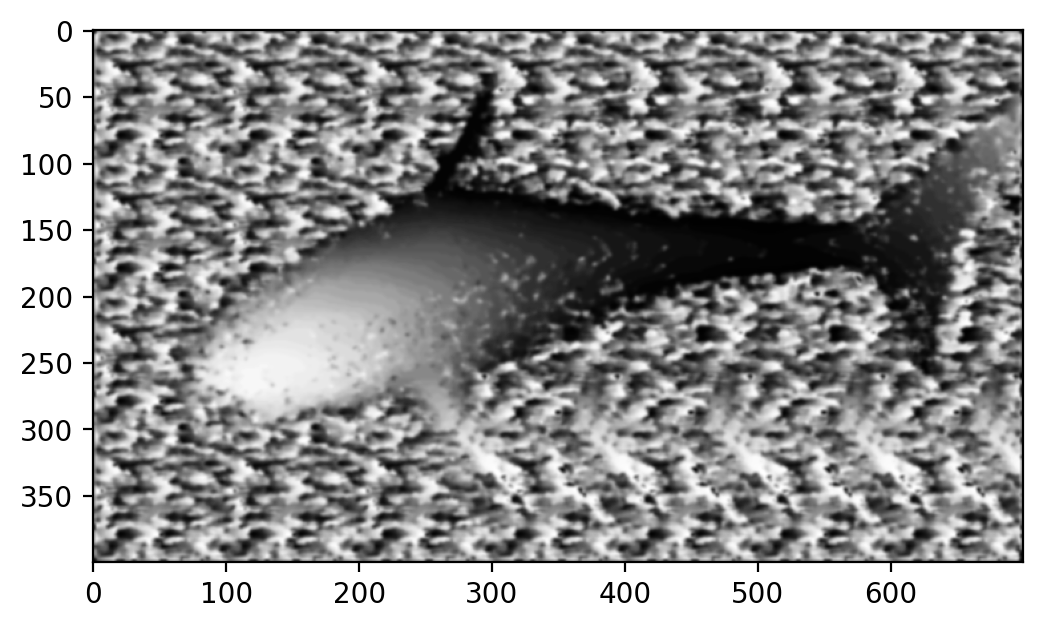

In [48]:
# create the cleaned up output
print(type(dmap))
print(dmap.shape)
dmap = dmap.astype('uint8')
print(type(dmap[0, 0]))
result = cv2.GaussianBlur(1 - cv2.cv2.equalizeHist(cv2.medianBlur(dmap, 5)), (5,5), 0) 
plt.imshow(result, cmap="gray")
plt.show()